In [13]:
from sympy import Symbol,solve
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats
%matplotlib inline
r_m=76.2
beta_T=0.82
h_0=2.46
c=0.05
x_f=26.6
beta_f=0.28
q_f=0.83
A=3.55
beta_g=beta_f
x_g=x_f
p=30
N=5000

In [14]:
#Firing rate pattern
xi_pattern=np.random.normal(0,1,size=(p,N))
r_pattern=r_m/(1+np.exp(-beta_T*(xi_pattern-h_0)))
print(r_pattern)

[[18.87623184  5.28082794 11.41541264 ... 21.68266773  9.54669258
  22.87143448]
 [17.25009562  4.24075296 12.45963511 ...  6.38282878  1.20098506
  16.41267053]
 [ 6.58219855 38.21777499  5.01328291 ...  3.91787474 14.26905039
   7.13067995]
 ...
 [13.45014895 30.305244   15.11559949 ... 15.01097624 20.42640613
   3.44398824]
 [ 1.32397007  8.94259609  8.01285067 ...  8.57189116  9.53630606
   3.60291752]
 [ 4.05851401  4.28906839  2.94689959 ... 25.81287424 11.88963032
   3.95057628]]


In [15]:
# Structral connectivity matrix
C=np.zeros((N,N),dtype='int8')
for i in range(N):
    for j in range(N):
        if random.uniform(0,1)<c:
            C[i,j]=1

In [16]:
#x = Symbol('x')
#def func(z):
#    I=np.exp(-z**2/2)*(2*x-1+np.tanh(beta_g*(r_m/(1+np.exp(-beta_T*(z-h_0)))-x_g)))
#    return I
#Sum2=0
#for i in range(N):
#    Sum2=Sum2+func(xi_pattern[0,i])
#q_g=solve(Sum2,x)[0]
#print(q_g)

In [17]:
#Final connectivity matrix J
q_g=0.99
def f(r):
    return 0.5*(2*q_f-1+np.tanh(beta_f*(r-x_f)))
def g(r):
    return 0.5*(2*q_g-1+np.tanh(beta_g*(r-x_g)))
def phi(xi):
    return r_m/(1+np.exp(-beta_T*(xi-h_0)))

In [18]:
#equation 2
J=np.zeros((N,N))
Sum=np.zeros((N,N))
for k in range(p):
    Sum=Sum+np.dot(f(np.transpose(r_pattern[k])).reshape(N,1),g(r_pattern[k]).reshape(1,N))
J=A*C/c/N*Sum
for i in range(N):
    J[i,i]=0

In [19]:
# initial firing rate
r0=np.random.uniform(0,5,N)
#for i in range(p):
#    for j in range(N):
#        r0[j]=np.random.normal(r_pattern[i,j],1)
print(r0)

[3.51816097 4.3260253  4.78444688 ... 1.04458676 0.92776675 3.95732797]


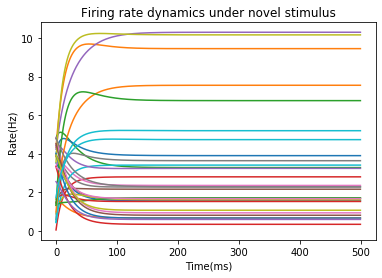

In [20]:
#Novel stimulus

tau=20
t_delay=500
r=np.zeros((N,t_delay))
dt=1
I0=1
#E_novel=np.zeros((p,t_delay))
E_novels=np.zeros(p)
r_novel=np.zeros((N,p))
#E_novels=np.zeros(t_max)
for i in range(p):
    ita=np.random.normal(0,1,size=N)
    I=I0*ita
    r[:,0]=r0
    for t in range(1,t_delay):
        xi=np.dot(J,r[:,t-1])
        r[:,t]=r[:,t-1]+(-r[:,t-1]+phi(I+xi))/tau*dt #equation 1
        #E_novel[i,t]=-1/2*np.sum(np.dot(r[:,t].reshape(N,1),r[:,t].reshape(1,N))*J)
    E_novels[i]=-1/2*np.sum(np.dot(r[:,t_delay-1].reshape(N,1),r[:,t_delay-1].reshape(1,N))*J)
    r_novel[:,i]=r[:,t_delay-1]
plt.figure()
plt.title('Firing rate dynamics under novel stimulus')
plt.xlabel('Time(ms)')
plt.ylabel('Rate(Hz)')
#plt.vlines(t_pre-t_p, 0,80, colors = "grey", linestyles = "dashed",linewidth=2)
#plt.vlines(t_delay, 0,80, colors = "grey", linestyles = "dashed",linewidth=2)
for i in range(30):
    plt.plot(range(0,t_delay),r[i])
r1=np.copy(r)
#plt.savefig('Figures/novel_stimulus.png')

import seaborn as sns
plt.figure()
plt.title('Firing rate distribution under novel stimulus')
plt.xlabel('Rate(Hz)')
plt.ylabel('Probability Density')
sns.kdeplot(r[:,t_delay-1],label='Presentation')
sns.kdeplot(r[:,t_max-1],label='Delay')
plt.savefig('Figures/distribution_novel.png')

#Overlap
import scipy.stats
plt.figure()
plt.ylim(-0.2,1)
plt.title('Overlap under novel stimulus')
plt.xlabel('Time(s)')
plt.ylabel('Overlap(m)')

for i in range(p):
    ita=np.random.normal(0,1,size=N)
    I=I0*ita
    r[:,0]=r0
    for t in range(1,t_pre):
        xi=np.dot(J,r[:,t-1])
        r[:,t]=r[:,t-1]+(-r[:,t-1]+phi(xi))/tau*dt #equation 1
    for t in range(t_pre,t_delay):
        xi=np.dot(J,r[:,t-1])
        r[:,t]=r[:,t-1]+(-r[:,t-1]+phi(I+xi))/tau*dt #equation 1
    for t in range(t_delay,t_max):
        xi=np.dot(J,r[:,t-1])
        r[:,t]=r[:,t-1]+(-r[:,t-1]+phi(xi))/tau*dt #equation 1
    p_r=np.zeros(t_max-t_p)
    for t in range(0,t_max-t_p):
        p_r[t]=scipy.stats.pearsonr(r[:,t+t_p],r_pattern[i])[0]
    plt.plot(range(0,t_max-t_p),p_r)
plt.savefig("Figures/overlap_novel.png")

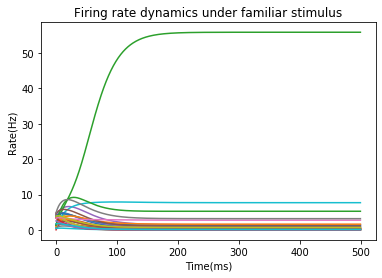

In [21]:
#Familiar Stimulus
E_familiar=np.zeros((p,t_delay))
r_familiar=np.zeros((N,p))
E_familiars=np.zeros(p)
#E_familiars=np.zeros(t_max)
for i in range(p):
    I=I0*xi_pattern[i]
    r[:,0]=r0
    for t in range(1,t_delay):
        xi=np.dot(J,r[:,t-1])
        r[:,t]=r[:,t-1]+(-r[:,t-1]+phi(I+xi))/tau*dt #equation 1
        #E_familiar[i,t]=-1/2*np.sum(np.dot(r[:,t].reshape(N,1),r[:,t].reshape(1,N))*J)
    E_familiars[i]=-1/2*np.sum(np.dot(r[:,t_delay-1].reshape(N,1),r[:,t_delay-1].reshape(1,N))*J)
    r_familiar[:,i]=r[:,t_delay-1]
plt.figure()
plt.title('Firing rate dynamics under familiar stimulus')
plt.xlabel('Time(ms)')
plt.ylabel('Rate(Hz)')
for i in range(30):
    plt.plot(range(0,t_delay),r[i])
#plt.vlines(t_pre-t_p, 0,80, colors = "grey", linestyles = "dashed",linewidth=2)
#plt.vlines(t_delay, 0,80, colors = "grey", linestyles = "dashed",linewidth=2)
r2=np.copy(r)
#plt.savefig('Figures/familiar_stimulus.png')

#familiarity
plt.figure()
plt.title('FamE')
plt.ylabel('Energy')
plt.xlabel('Time (ms)')
plt.plot(range(0,1000),E_novel[t_pre:t_pre+1000])
plt.plot(range(0,1000),E_familiar[t_pre:t_pre+1000])
plt.legend(['novel','familiar'])

dE_novel=np.zeros((p,1000))
dE_familiar=np.zeros((p,1000))
for t in range(1,1000):
    dE_novel[:,t]=E_novel[:,t]-E_novel[:,t-1]
    dE_familiar[:,t]=E_familiar[:,t]-E_familiar[:,t-1]
plt.figure()
plt.title('FamS')
plt.ylabel('Slope')
plt.xlabel('Time (ms)')
for i in range(p):
    plt.plot(range(0,1000),dE_novel[i])
    plt.plot(range(0,1000),dE_familiar[i])
#plt.legend(['novel','familiar'])

SNR=np.zeros(1000)
d=np.zeros(1000)
d2=np.zeros(1000)
for t in range(1,1000):
    #SNR[t]=2*np.abs(np.mean(E_novel[:,t])-np.mean(E_familiar[:,t]))/(np.std(E_novel[:,t])+np.std(E_familiar[:,t]))
    d[t]=1/2*(1-np.dot(r1[:,t],r_pattern[0])/np.linalg.norm(r1[:,t])/np.linalg.norm(r_pattern[0]))
    d2[t]=1/2*(1-np.dot(r2[:,t],r_pattern[0])/np.linalg.norm(r_pattern[0])/np.linalg.norm(r2[:,t]))
plt.figure()
plt.title('SNR(FamE)')
plt.xlabel('Time (ms)')
plt.ylabel('Familiarity')
#plt.plot(range(1000),SNR)

SNR_S=np.zeros(1000)
for t in range(1,1000):
    SNR_S[t]=2*np.abs(np.mean(dE_novel[:,t])-np.mean(dE_familiar[:,t]))/(np.std(dE_novel[:,t])+np.std(dE_familiar[:,t]))
plt.figure()
plt.title('SNR(FamS)')
plt.xlabel('Time (ms)')
plt.ylabel('Familiarity')
plt.plot(range(1000),SNR_S)

plt.figure()
plt.title('Recollection')
plt.xlabel('Time (ms)')
plt.ylabel('Distance value')
plt.plot(range(1000),d)
plt.plot(range(1000),d2)
plt.legend(['New','Old'])

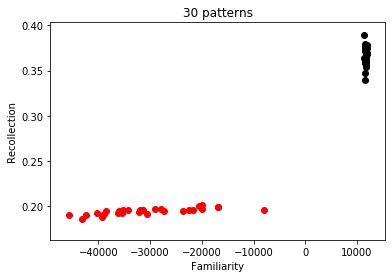

In [22]:
plt.figure()
plt.title('30 patterns')
plt.ylabel('Recollection')
plt.xlabel('Familiarity')
for i in range(p):
    plt.scatter(E_familiars[i],1/2*(1-np.dot(r_familiar[:,i],r_pattern[i])/np.linalg.norm(r_familiar[:,i])/np.linalg.norm(r_pattern[i])),c='r')
    plt.scatter(E_novels[i],1/2*(1-np.dot(r_novel[:,i],r_familiar[:,i])/np.linalg.norm(r_novel[:,i])/np.linalg.norm(r_familiar[:,i])),c='k')


plt.figure()
plt.title('Firing rate distribution under familiar stimulus')
plt.xlabel('Rate(Hz)')
plt.ylabel('Probability Density')
sns.kdeplot(r[:,t_delay-1],label='Presentation')
sns.kdeplot(r[:,t_max-1],label='Delay')
plt.savefig('Figures/distribution_familiar.png')

#Overlap
plt.figure()
plt.ylim(0,1)
plt.title('Overlap under familiar stimulus')
plt.xlabel('Time(s)')
plt.ylabel('Overlap(m)')

for i in range(p):
    I=I0*xi_pattern[i]
    r[:,0]=r0
    for t in range(1,t_pre):
        xi=np.dot(J,r[:,t-1])
        r[:,t]=r[:,t-1]+(-r[:,t-1]+phi(xi))/tau*dt #equation 1
    for t in range(t_pre,t_delay):
        xi=np.dot(J,r[:,t-1])
        r[:,t]=r[:,t-1]+(-r[:,t-1]+phi(I+xi))/tau*dt #equation 1
    for t in range(t_delay,t_max):
        xi=np.dot(J,r[:,t-1])
        r[:,t]=r[:,t-1]+(-r[:,t-1]+phi(xi))/tau*dt #equation 1
    p_r=np.zeros(t_max-t_p)
    for t in range(0,t_max-t_p):
        p_r[t]=scipy.stats.pearsonr(r[:,t+t_p],r_pattern[i])[0]
    plt.plot(range(0,t_max-t_p),p_r)
plt.savefig("Figures/overlap_familiar.png")

In [23]:
print(E_novel[:,t_delay-1])

NameError: name 'E_novel' is not defined

In [ ]:
print(E_familiar[:,t_delay-1])

In [ ]:
E=[-62068.41284332,-51706.43641277,-34893.90253154,-33125.8795448,
-48851.88464377,-67131.88332689, -35527.07608843, -51408.04164733,
 -53260.02083854, -35333.29496986]
import numpy as np
print(np.mean(E))
print(np.var(E))

In [ ]:
E=[-43164.61231176, -41554.26172718, -42808.69314877, -41475.40420487,
 -39767.71336006, -42344.19212185, -42173.03925208, -41622.05035232,
 -41607.99372615, -37727.2712618 ]
print(np.mean(E))
print(np.var(E))

In [24]:
print(E_novels)

[11711.89257636 11334.52666833 11623.82638176 12015.58712287
 11722.24424242 11465.68456438 11489.98048917 11663.01328403
 11803.59063029 11879.44183775 11809.53141556 11610.84413564
 11741.34418939 11584.59419176 11681.97237668 11650.59222707
 11678.63843307 11667.32283846 11353.66187868 11550.38685188
 11928.24601994 11559.534514   11622.49398277 11903.36252908
 11664.15165197 11755.54350869 11767.08533489 11604.66183929
 11535.98110189 11810.02769318]
